In [1]:
pip install opendatasets

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/virajbagal/roco-dataset?select=all_data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: siddheshatkar
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/virajbagal/roco-dataset


100%|██████████| 6.19G/6.19G [01:09<00:00, 95.0MB/s]


In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.applications import ResNet50
from keras.layers import LSTM, Dense, Embedding, RepeatVector, TimeDistributed, Input, Flatten
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from PIL import Image

In [4]:
# Read CSV dataset from Pandas
df_train = pd.read_csv('/content/roco-dataset/all_data/train/radiologytraindata.csv', delimiter=',') #, nrows = nRowsRead
df_train.dataframeName = '/content/roco-dataset/all_data/test/radiologytestdata.csv'
nRow, nCol = df_train.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 65450 rows and 3 columns


In [5]:
print(df_train.head())

           id                                    name  \
0  ROCO_00002          PMC4083729_AMHSR-4-14-g002.jpg   
1  ROCO_00003       PMC2837471_IJD2009-150251.001.jpg   
2  ROCO_00004  PMC2505281_11999_2007_30_Fig6_HTML.jpg   
3  ROCO_00005       PMC3745845_IJD2013-683423.005.jpg   
4  ROCO_00007   PMC4917066_amjcaserep-17-301-g001.jpg   

                                             caption  
0   Computed tomography scan in axial view showin...  
1   Bacterial contamination occurred after comple...  
2   The patient had residual paralysis of the han...  
3    Panoramic radiograph after immediate loading.\n  
4   Plain abdomen x-ray: Multiple air levels at t...  


In [6]:
df_train['images'] = "/kaggle/input/roco-dataset/all_data/train/radiology/images/" + df_train['name']
df_train.head()

,id,name,caption,images
0,ROCO_00002,PMC4083729_AMHSR-4-14-g002.jpg,Computed tomography scan in axial view showin...,/kaggle/input/roco-dataset/all_data/train/radi...
1,ROCO_00003,PMC2837471_IJD2009-150251.001.jpg,Bacterial contamination occurred after comple...,/kaggle/input/roco-dataset/all_data/train/radi...
2,ROCO_00004,PMC2505281_11999_2007_30_Fig6_HTML.jpg,The patient had residual paralysis of the han...,/kaggle/input/roco-dataset/all_data/train/radi...
3,ROCO_00005,PMC3745845_IJD2013-683423.005.jpg,Panoramic radiograph after immediate loading.\n,/kaggle/input/roco-dataset/all_data/train/radi...
4,ROCO_00007,PMC4917066_amjcaserep-17-301-g001.jpg,Plain abdomen x-ray: Multiple air levels at t...,/kaggle/input/roco-dataset/all_data/train/radi...


In [7]:
# Display basic information about the DataFrame
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65450 entries, 0 to 65449
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       65450 non-null  object
 1   name     65450 non-null  object
 2   caption  65450 non-null  object
 3   images   65450 non-null  object
dtypes: object(4)
memory usage: 2.0+ MB
None


In [9]:
# Display statistical summary of numerical columns
print(df_train.describe())

                id                            name  \
count        65450                           65450   
unique       65450                           65450   
top     ROCO_00002  PMC4083729_AMHSR-4-14-g002.jpg   
freq             1                               1   

                                 caption  \
count                              65450   
unique                             64772   
top      Initial panoramic radiograph.\n   
freq                                  19   

                                                   images  
count                                               65450  
unique                                              65450  
top     /kaggle/input/roco-dataset/all_data/train/radi...  
freq                                                    1  


In [10]:
# Display unique values for categorical columns
for column in df_train.select_dtypes(include=['object']).columns:
    print(f'Unique values in {column}: {df_train[column].unique()}')

Unique values in id: ['ROCO_00002' 'ROCO_00003' 'ROCO_00004' ... 'ROCO_81821' 'ROCO_81822'
 'ROCO_81823']
Unique values in name: ['PMC4083729_AMHSR-4-14-g002.jpg' 'PMC2837471_IJD2009-150251.001.jpg'
 'PMC2505281_11999_2007_30_Fig6_HTML.jpg' ...
 'PMC2974222_kjr-11-612-g001.jpg' 'PMC3532764_AJNS-7-151-g002.jpg'
 'PMC3509000_pone.0050319.g002.jpg']
Unique values in caption: [' Computed tomography scan in axial view showing obliteration of the left maxillary sinus\n'
 ' Bacterial contamination occurred after completion of root canal treatment in the tooth, which remained with a temporary filling for 15 month.\n'
 ' The patient had residual paralysis of the hand after poliomyelitis. It was necessary to stabilize the thumb with reference to the index finger. This was accomplished by placing a graft from the bone bank between the first and second metacarpals. The roentgenogram shows the complete healing of the graft one year later.\n'
 ...
 ' Primary pulmonary tuberculosis in 18-year-old boy

In [11]:
# Check for missing values
print(df_train.isnull().sum())

id         0
name       0
caption    0
images     0
dtype: int64


In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
# Encode categorical columns using LabelEncoder
label_encoder = LabelEncoder()

for column in df_train.select_dtypes(include=['object']).columns:
    df_train[column] = label_encoder.fit_transform(df_train[column])

In [13]:
X = df_train.drop(columns=['caption'])  # replace 'target_column' with the actual target column name
y = df_train['id']  # replace 'target_column' with the actual target column name


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (52360, 3)
Shape of X_test: (13090, 3)
Shape of y_train: (52360,)
Shape of y_test: (13090,)


In [15]:
# Load the ROCO dataset
train_dir = '/content/roco-dataset/all_data/train/radiologytraindata.csv'
test_dir = '/content/roco-dataset/all_data/test/radiologytestdata.csv'
train_images = []
train_captions = []
test_images = []
test_captions = []

In [16]:
for filename in os.listdir('/content/roco-dataset/all_data/train/radiology'):
    if filename.endswith(".jpg"):
        img = Image.open(os.path.join('/content/roco-dataset/all_data/train/radiology/images', images))
        img = img.resize((224, 224))
        train_images.append(np.array(img))
        with open(os.path.join('/content/roco-dataset/all_data/train/radiology', filename[:-4] + '.txt'), 'r') as f:
            caption = f.read()
            train_captions.append(caption)

for filename in os.listdir('/content/roco-dataset/all_data/test/radiology'):
    if filename.endswith(".jpg"):
        img = Image.open(os.path.join('/content/roco-dataset/all_data/test/radiology/images', images))
        img = img.resize((224, 224))
        test_images.append(np.array(img))
        with open(os.path.join(test_dir, filename[:-4] + '.txt'), 'r') as f:
            caption = f.read()
            test_captions.append(caption)

In [17]:
# Preprocess the captions
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_captions)

train_sequences = tokenizer.texts_to_sequences(train_captions)
test_sequences = tokenizer.texts_to_sequences(test_captions)

max_caption_length = 30
vocab_size = len(tokenizer.word_index) + 1

train_padded = pad_sequences(train_sequences, maxlen=max_caption_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_caption_length, padding='post')

In [18]:
# One-hot encode the captions
num_classes = vocab_size
train_onehot = np.zeros((len(train_padded), max_caption_length, num_classes))
test_onehot = np.zeros((len(test_padded), max_caption_length, num_classes))

for i, sequence in enumerate(train_padded):
    for j, word in enumerate(sequence):
        train_onehot[i, j, word] = 1

for i, sequence in enumerate(test_padded):
    for j, word in enumerate(sequence):
        test_onehot[i, j, word] = 1

In [19]:
# Define the encoder (ResNet50)
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in resnet.layers:
    layer.trainable = False

image_input = Input(shape=(224, 224, 3))
encoded_features = resnet(image_input)
encoded_features = Flatten()(encoded_features)
encoded_features = RepeatVector(max_caption_length)(encoded_features)

94765736/94765736 [==============================] - 0s 0us/step


In [20]:
# Define the decoder (LSTM)
from keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Reshape

# Define the decoder (LSTM)
decoder_inputs = Input(shape=(max_caption_length, 1))
decoder_embedding = Embedding(vocab_size, 256)(decoder_inputs)
decoder_embedding = Reshape((max_caption_length, 256))(decoder_embedding)
decoder_lstm = LSTM(256, return_sequences=True)(decoder_embedding)
decoder_dense = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder_lstm)

In [21]:
# Define the model
model = Model(inputs=[image_input, decoder_inputs], outputs=decoder_dense)

In [22]:
import tensorflow as tf

In [23]:
# Define maxlen
maxlen = 30

In [24]:
# Create the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=100, output_dim=10, input_length=maxlen),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

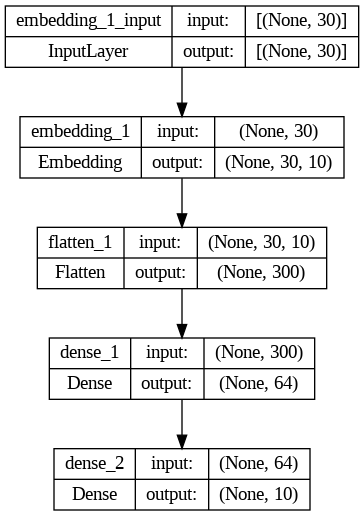

In [25]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [26]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
print("Train padded shape:", train_padded.shape)
print("Train onehot shape:", train_onehot.shape)

Train padded shape: (0, 30)
Train onehot shape: (0, 30, 1)


In [28]:
import pandas as pd

test_raw = pd.read_csv('/content/roco-dataset/all_data/test/radiologytestdata.csv')
train_raw = pd.read_csv('/content/roco-dataset/all_data/train/radiologytraindata.csv')

In [29]:
# Print the shapes of the data arrays
print('train_images shape:', np.array(train_images).shape)
print('train_padded shape:', np.array(train_padded).shape)
print('train_onehot shape:', np.array(train_onehot).shape)
print('test_images shape:', np.array(test_images).shape)
print('test_padded shape:', np.array(test_padded).shape)
print('test_onehot shape:', np.array(test_onehot).shape)

# Check if the arrays are empty
print('Is train_images empty?', len(train_images) == 0)
print('Is train_padded empty?', len(train_padded) == 0)
print('Is train_onehot empty?', len(train_onehot) == 0)
print('Is test_images empty?', len(test_images) == 0)
print('Is test_padded empty?', len(test_padded) == 0)
print('Is test_onehot empty?', len(test_onehot) == 0)


train_images shape: (0,)
train_padded shape: (0, 30)
train_onehot shape: (0, 30, 1)
test_images shape: (0,)
test_padded shape: (0, 30)
test_onehot shape: (0, 30, 1)
Is train_images empty? True
Is train_padded empty? True
Is train_onehot empty? True
Is test_images empty? True
Is test_padded empty? True
Is test_onehot empty? True


In [ ]:
# Train the model
model.fit(
    [np.array(train_images), train_padded],
    train_onehot,
    epochs=10,
    validation_data=([np.array(test_images), test_padded], test_onehot),
    callbacks=[checkpoint]
)

In [ ]:
# Evaluate the model on the test set
scores = model.evaluate([np.array(test_images), test_padded], test_onehot, verbose=1)
print('Test Loss:', scores[0])
print('Test Accuracy:', scores[1])

In [ ]:
# Generate captions
def generate_caption('ROCO_00005'):
    img = Image.open('ROCO_00005')
    img = img.resize((224, 224))
    img = np.array(img)
    img = img.reshape((1, 224, 224, 3))

    start_seq = np.array([[tokenizer.word_index['startseq']]])
    generated_caption = ''

    for i in range(max_caption_length):
        decoder_input = np.zeros((1, max_caption_length, 1))
        decoder_input[0, i, 0] = start_seq[0, 0]